In [5]:
# Libraries for data wrangling
import pandas as pd
import numpy as np

# Machine learning functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_recall_curve

#import torch
#import torch.nn as nn

from xgboost import XGBClassifier

# Downsampling function from imblearn, a library to manipulate imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Data visualization functions
import matplotlib.pyplot as plt
import seaborn as sns


### Define the random seed for the rest of the notebook

In [6]:
    seed = 20201106 # the deadline date

## _Step 1:_ Loading the raw dataset

In [8]:
# Load raw data 
df = pd.read_csv('data/SambnisImp.csv', index_col=0)

# Print dimension information about the dataset
print(f'Raw data dimensions: {df.shape}')

# Print first 5 columns
df.head()

Raw data dimensions: (7140, 285)


,atwards,X,id,cid,cowcode,year,warstds,ptime,yrint,autonomy,...,decade1,decade2,decade3,decade4,independ,tip,anocracy,proxregc,sxpnew.2,sxpsq.2
1,0,1,1.0,1,700,1945,0,12,0,0.005151,...,0,0,0,0,1,17.0,0,0.143299,0.094095,0.094095
2,0,2,1.0,1,700,1946,0,24,1,0.000000,...,0,0,0,0,1,18.0,0,1.000000,0.094547,0.094547
3,0,3,1.0,1,700,1947,0,36,2,0.000000,...,0,0,0,0,1,19.0,0,1.000000,0.095567,0.095567
4,0,4,1.0,1,700,1948,0,48,3,0.000000,...,0,0,0,0,1,20.0,0,1.000000,0.101303,0.101303
5,0,5,1.0,1,700,1949,0,60,4,0.000000,...,0,0,0,0,1,21.0,0,1.000000,0.092107,0.092107


### Copy the data columns used by Muchlinski et al. (2016)

In [9]:
# Columns used in the Random Forests model from Muchlinski et al. (2016)

rf_cols = ["ager", "agexp", "anoc", "army85", 
           "autch98", "auto4", "autonomy", "avgnabo",
           "centpol3", "coldwar", "decade1", "decade2", 
           "decade3", "decade4", "dem", "dem4",
           "demch98", "dlang", "drace", "drel", 
           "durable", "ef", "ef2", "ehet", 
           "elfo", "elfo2", "etdo4590", "expgdp", 
           "exrec", "fedpol3", "fuelexp", "gdpgrowth", 
           "geo1", "geo2", "geo34", "geo57",
           "geo69", "geo8", "illiteracy", "incumb", 
           "infant", "inst", "inst3", "life",
           "lmtnest", "major", "manuexp", "milper",
           "mirps0", "mirps1", "mirps2", "mirps3", 
           "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
           "numlang", "nwstate", "oil", "p4mchg", 
           "parcomp", "parreg", "part", "partfree", 
           "plural", "plurrel", "pol4", "pol4m", 
           "pol4sq", "polch98", "polcomp", "popdense", 
           "presi", "pri", "proxregc", "reg", 
           "regd4_alt", "relfrac", "seceduc", "second",
           "semipol3", "sip2", "sxpnew", "sxpsq",
           "tnatwar", "trade", "warhist", "xconst"]

In [10]:
def load_data(df, data_cols, label_col='warstds'):
    '''
    Select columns of interest from raw data
    Separate data farme of interest into data matrix and labels
    
    Parameters
    ----------
    df: pandas.DataFrame
        Raw dataframe
    data_cols: list
        List of data columns to select the build the data matrix
    label_col: str
        Name of label column (ground truth)
    
    Returns
    ----------
    X: ndarray
        The data matrix with the regressors
    y: ndarray
        A vector with the ground truth labels
    '''
    
    X = df.loc[:, data_cols].to_numpy()
    y = df.loc[:, label_col].to_numpy()
    
    print(f'Shape of dataset: {X.shape}')
    
    return X, y

In [11]:
X, y = load_data(df, rf_cols)

Shape of dataset: (7140, 88)


In [174]:
params_rf = {'classification__n_estimators': [100],
             'classification__max_features': ['auto', 'log2'],
             'classification__random_state': [seed],
             'classification__max_samples' : [2/3, 1],
             'sampling__sampling_strategy': [0.125, 0.25, 0.5],
             'sampling__random_state': [seed]
            }

params_xgb = {'classification__n_estimators': [100],
              'classification__max_depth':[3, 6, 9], # Standard = 6, try 50% and 150% of default value
              'classification__subsample': [2/3, 1], # Equivalent to max_samples 
              'classification__random_state': [seed],
              'classification__booster': ['gbtree'], # Standard booster
              'sampling__sampling_strategy': [0.125, 0.25, 0.5], # Different downsampling strategies (12.5%-25%-50% of war events)
              'sampling__random_state': [seed]
             }

params_nn = {'classification__learning_rate': ['adaptive'],
             'classification__alpha': [1e-4, 1e-3, 1e-2],
             'classification__hidden_layer_sizes': [(X.shape[1],)*4, (X.shape[1],)*8], 
             'classification__learning_rate_init': [1e-3],
             'classification__random_state': [seed],
             'sampling__sampling_strategy': [0.125, 0.25, 0.5],
             'sampling__random_state': [seed]
            }

In [175]:
rf = Pipeline([('sampling', RandomUnderSampler()),
               ('classification', RandomForestClassifier())])

xgb = Pipeline([('sampling', RandomUnderSampler()),
                ('classification', XGBClassifier())])

nn = Pipeline([('sampling', RandomUnderSampler()),
               ('classification', MLPClassifier())])

In [176]:
grid = []

def fit_predict(X, y, clf, params, 
                test_size=0.15, n_splits=10, 
                scoring='average_precision', 
                seed=seed, normalize=False):
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    # Standardize features for MLP
    if normalize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Apply Grid Search CV
    grid = GridSearchCV(clf, params, cv=n_splits, scoring=scoring, verbose=1)
    grid.fit(X_train, y_train)
    
    # Predict probabilities and labels
    y_pred_proba = grid.predict_proba(X_test)[:,1]
    y_pred = grid.predict(X_test)
    
    # PR curve is more adapted to imbalanced datasets than ROC-AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    
    # Get metrics
    pr_auc = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    
    return precision, recall, pr_auc, roc_auc, f1, grid

In [177]:
comparison_data = {}

In [178]:
p_rf, r_rf, pr_auc_rf, roc_auc_rf, f1_rf, grid_rf = fit_predict(X, y, rf, params_rf)

comparison_data['RF'] = {'PR': pr_auc_rf, 'ROC': roc_auc_rf, 'F1': f1_rf}

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   48.5s finished


In [179]:
p_xgb, r_xgb, pr_auc_xgb, roc_auc_xgb, f1_xgb, grid_xgb= fit_predict(X, y, xgb, params_xgb)

comparison_data['XGB'] = {'PR': pr_auc_xgb, 'ROC': roc_auc_xgb, 'F1': f1_xgb}

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   34.9s finished


In [96]:
p_nn, r_nn, pr_auc_nn, roc_auc_nn, f1_nn, grid_nn = fit_predict(X, y, nn, params_nn, normalize=True)

comparison_data['NN'] = {'PR': pr_auc_nn, 'ROC': roc_auc_nn, 'F1': f1_nn}

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 17.5min finished


In [19]:
pd.DataFrame.from_dict(comparison_data).round(4)

,RF,XGB,NN
PR,0.3636,0.5164,0.1889
ROC,0.9332,0.9460,0.8166
F1,0.4000,0.4308,0.1429


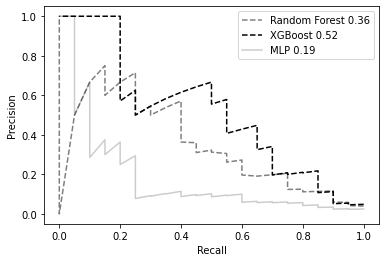

In [20]:
plt.plot(r_rf, p_rf, 'k--', label=f'Random Forest {pr_auc_rf:.2f}', alpha=0.5)
plt.plot(r_xgb, p_xgb, 'k--', label=f'XGBoost {pr_auc_xgb:.2f}')
plt.plot(r_nn, p_nn, 'k', label=f'MLP {pr_auc_nn:.2f}', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Importance xgb

In [49]:
var_names = ["Age in years of the current regime as classified by REG; ACLP"
,"Agricultural raw materials exports as percentage of merchandise exports; WDI"
,"Dummy: Anocracy=1"
, "Size of government army in 1985"
, "Autocracy annual change; Polity 98"
, "Autocracy index from Polity IV"
, "Country has de facto autonomous regions"
, "Average SIP score of neighbors"
, "Centralized state? (Polity III data plus updates for post-1994)"
, "Code 1 for Cold War year - before 1990"
, "Dummy : 1960s"
,"Dummy : 1970s"
,"Dummy : 1980s"
,"Dummy : 1990s"
,"Dummy: 1 for democracies and 0 for autocracies"
,"Democracy index from Polity IV"
,"Democracy annual change; Polity 98"
,"Linguistic component of Ehet"
,"Racial component of Ehet"
,"Religious component of Ehet"
,"Years since last regime transition/since 1949; Polity IV"
,"Ethnic fractionalization index"
,"Ef squared"
,"Ethnic heterogeneity index"
,"Ethnolinguistic diversity"
,"Ethnolinguistic diversity, squared"
,"Ethnic dominance measure"
,"Exports of goods & services as %GDP; WDI data"
,"Executive recruitment concept variable; Polity IV"
,"Federal state? (Polity III data plus updates for post-1994)"
,"Fuel and oil products exports as percentage of merchandise exports;WDI"
,"Annual change in GDP, %"
,"Region: Western Europe and the US"
,"Region: Eastern Europe and Central Asia"
,"Region: Middle East and North Africa"
,"Region: South and East Asia and Oceania"
,"Region: Latin America"
,"Region: Sub-Saharan Africa"
,"% adult population illiterate; WDI"
,"Consolidation of incumbent advantage(Przeworski et al., 2000)"
,"Infant mortality; WDI"
,"0-dict; 1-parliam; 2-mixed dem; 3-pres dem (Przeworski et al., 2000)"
,"Political instability; Whether Polity coded a change or 77 or 88 in previous three years"
,"Life Expectancy at birth; WDI"
,"Rough terrain"
,"Majoritarian system"
,"Manufactures exports as percentage of merchandise exports; WDI"
,"Military manpower in thousands"
,"Inconsistent polity (semi-democracy)"
,"Caesaristic polity"
,"Consistent autocracy"
,"Consistent democracy"
,"Whether a neighbor is at war in a given year."
,"Noncontiguous state"
,"Neighbors’ average ln(GDP per capita)"
,"Neighbors’ median polity (both land and water contiguity; using polity2)"
,"Number of languages in Ethnologue"
,"New state"
,"Oil exports/GDP"
,"Annual change in modified polity; Polity IV"
,"Competitiveness of participation; non-elites; Polity IV"
,"Regulation of participation; Polity IV"
,"ln(share of population voting x opposition’s share of votes cast)"
,"Partially free polity"
,"Share of largest ethnic group"
,"Size of largest confession"
,"Polity index; Polity IV"
,"Polity Index; Polity IV; 77 & 88 coded=0"
,"Pol4 squared"
,"Polity annual change; Polity98"
,"Political competition: concept variable; Polity IV"
,"Population density: people per square km; WDI"
,"Presidential system"
,"School enrollment, primary, %gross; WDI"
,"2^(-durable/.5)"
,"Dummy: 1 for dictatorships and 0 for democracies; ACLP"
,"Median Regional polity (using polity2)"
,"Religious fractionalization"
,"School enrollment, secondary, %gross; WDI"
,"Percent population in second largest group"
,"Semi-federal state? (Polity III data plus updates for post-1994)"
,"Continuous measure of democracy"
,"Primary commodity exports/GDP"
,"Primary commodity exports/GDP, squared"
,"Total number of neighbors at war in a given year."
,"Trade as percept of GDP; in 1995 constant dollars"
,"War in the country since 1945?"
,"Executive constraints - operational independence of CE; Polity IV"]


zip_iterator = zip(rf_cols, var_names)
names_dict = dict(zip_iterator)

In [50]:
len(var_names)

88

In [78]:
feat_imp_score = grid.best_estimator_.named_steps['classification'].feature_importances_
importance = pd.DataFrame(data = np.transpose([rf_cols, var_names,feat_imp_score]), columns=["variable shortcut", "variable name", "importance"])
importance = importance.sort_values("importance",ascending=False)

In [90]:
importance = importance.astype({'importance': 'float'})

<AxesSubplot:xlabel='importance', ylabel='variable name'>

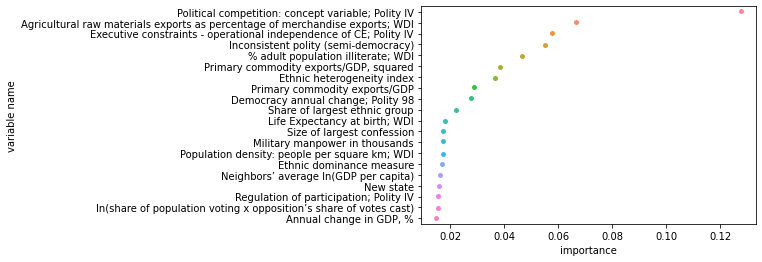

In [95]:
sns.stripplot(x="importance", y="variable name", data=importance.iloc[:20,:])

In [53]:
from eli5 import explain_weights
explain_weights(grid.best_estimator_.named_steps['classification'], top=50, feature_names=var_names)

Weight,Feature
0.1275,Political competition: concept variable; Polity IV
0.0665,Agricultural raw materials exports as percentage of merchandise exports; WDI
0.0577,Executive constraints - operational independence of CE; Polity IV
0.0550,Inconsistent polity (semi-democracy)
0.0467,% adult population illiterate; WDI
0.0386,"Primary commodity exports/GDP, squared"
0.0366,Ethnic heterogeneity index
0.0290,Primary commodity exports/GDP
0.0277,Democracy annual change; Polity 98
0.0223,Share of largest ethnic group


# Importance MLP

In [99]:
from sklearn.metrics import mean_absolute_error

In [104]:
grid_nn = grid

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
y_pred = grid_nn.predict(X_test)

MAE_base = mean_absolute_error(y_test,y_pred)
print(MAE_base)

0.0196078431372549


In [169]:
np.random.seed(seed)
n_turn = 200
importance_NN = np.zeros((n_turn, np.shape(X_test)[1]))

for i in range(n_turn):
    X_test_shuff = np.copy(X_test)
    np.random.shuffle(X_test_shuff,)
    
    for j in range(np.shape(X_test)[1]):
        X_test_imp = np.copy(X_test)
        X_test_imp[:,j] = X_test_shuff[:,j]
        y_pred = grid_nn.predict(X_test_imp)
        MAE_shuff = mean_absolute_error(y_test,y_pred)
        importance_NN[i,j] = (MAE_shuff - MAE_base)/MAE_base*100
    
    

In [170]:
print(np.sum(np.abs(X_test-X_test_shuff)))

258764083.6686464


In [171]:
print(np.mean(importance_NN, axis=0))

[ 2.66666667  0.          0.          3.33333333  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.38095238 -2.0952381   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.0952381   7.52380952
  0.          0.          0.          0.          0.          0.
 -2.19047619  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -2.76190476
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.52380952  0.          0.        ]


<AxesSubplot:xlabel='importance', ylabel='variable name'>

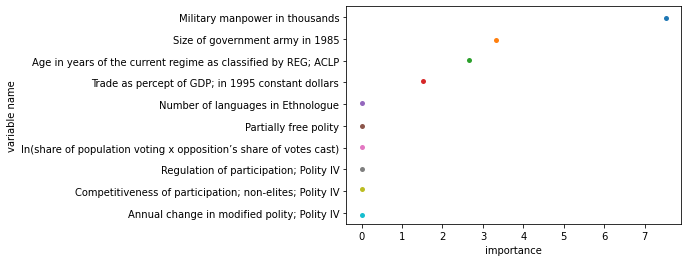

In [172]:
feat_imp_score = np.mean(importance_NN, axis=0)
importance = pd.DataFrame(data = np.transpose([rf_cols, var_names,feat_imp_score]), columns=["variable shortcut", "variable name", "importance"])
importance = importance.astype({'importance': 'float'})
importance = importance.sort_values("importance",ascending=False)
sns.stripplot(x="importance", y="variable name", data=importance.iloc[:10,:])

# Tests

In [173]:
grid_nn.best_params_

{'classification__alpha': 0.01,
 'classification__hidden_layer_sizes': (88, 88, 88, 88),
 'classification__learning_rate': 'adaptive',
 'classification__learning_rate_init': 0.001,
 'classification__random_state': 20201106,
 'sampling__random_state': 20201106,
 'sampling__sampling_strategy': 0.125}

In [180]:
grid_xgb.best_params_

{'classification__booster': 'gbtree',
 'classification__max_depth': 9,
 'classification__n_estimators': 100,
 'classification__random_state': 20201106,
 'classification__subsample': 1,
 'sampling__random_state': 20201106,
 'sampling__sampling_strategy': 0.125}

In [181]:
grid_rf.best_params_

{'classification__max_features': 'auto',
 'classification__max_samples': 0.6666666666666666,
 'classification__n_estimators': 100,
 'classification__random_state': 20201106,
 'sampling__random_state': 20201106,
 'sampling__sampling_strategy': 0.125}

In [38]:
'''class MLP(nn.Module):
    def __init__(self, n_layers, in_, hidden, out_ = 1):
        super(MLP, self).__init__()
        
        self.n_layers = n_layers
        self.in_ = in_
        self.hidden = hidden
        self.out_ = out_
        self.layers = self.create_layers()
    
    
    def create_layers(self):
        layers = [nn.Linear(self.in_, self.hidden), nn.ReLU()]
        
        for i in range(1, self.n_layers-1):
            layers.extend([nn.Linear(self.hidden, self.hidden), nn.ReLU()])
        
        layers.extend([nn.Linear(self.hidden, self.out_), nn.Sigmoid()])
        
        return nn.Sequential(*layers)                
    
    def forward(self, x):
        x = self.layers(x)
        return x'''

'class MLP(nn.Module):\n    def __init__(self, n_layers, in_, hidden, out_ = 1):\n        super(MLP, self).__init__()\n        \n        self.n_layers = n_layers\n        self.in_ = in_\n        self.hidden = hidden\n        self.out_ = out_\n        self.layers = self.create_layers()\n    \n    \n    def create_layers(self):\n        layers = [nn.Linear(self.in_, self.hidden), nn.ReLU()]\n        \n        for i in range(1, self.n_layers-1):\n            layers.extend([nn.Linear(self.hidden, self.hidden), nn.ReLU()])\n        \n        layers.extend([nn.Linear(self.hidden, self.out_), nn.Sigmoid()])\n        \n        return nn.Sequential(*layers)                \n    \n    def forward(self, x):\n        x = self.layers(x)\n        return x'

In [64]:
'''from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

xgb = MLPClassifier(hidden_layer_sizes=(88,88))

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, y_train = SMOTE(sampling_strategy=0.2,random_state=seed).fit_resample(X_train, y_train)

xgb.fit(X_train, y_train)

fpr, tpr, _ = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:,1])
    
f1_score(y_test, xgb.predict(X_test)), average_precision_score(y_test, xgb.predict_proba(X_test)[:,1])

#confusion_matrix(y_test, xgb.predict(X_test))'''

'from sklearn.metrics import confusion_matrix\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)\n\nxgb = MLPClassifier(hidden_layer_sizes=(88,88))\n\nscaler = StandardScaler()\n\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)\n\nX_train, y_train = SMOTE(sampling_strategy=0.2,random_state=seed).fit_resample(X_train, y_train)\n\nxgb.fit(X_train, y_train)\n\nfpr, tpr, _ = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:,1])\n    \nf1_score(y_test, xgb.predict(X_test)), average_precision_score(y_test, xgb.predict_proba(X_test)[:,1])\n\n#confusion_matrix(y_test, xgb.predict(X_test))'